In [1]:
import datasets
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
ds = datasets.load_dataset("mnist")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [5]:
loss_fn = torch.nn.BCELoss().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [6]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [7]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]["image"]
        if self.transform:
            img = self.transform(img)
            
        label = self.dataset[idx]["label"]
        
        return img, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_dataset = CustomDataset(ds["train"], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = CustomDataset(ds["test"], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
optimizer_G = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

  5%|▌         | 235/4700 [00:20<06:29, 11.46it/s]

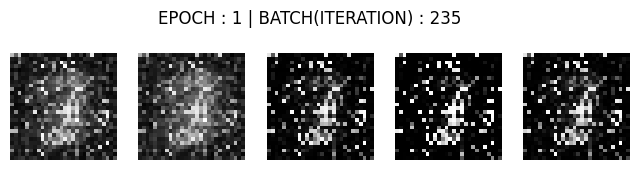

[Epoch 0/10] [D loss: 0.7274846434593201] [G loss: 1.0863940715789795]


 10%|▉         | 469/4700 [00:41<06:16, 11.25it/s]

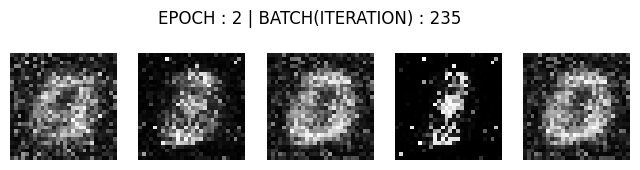

 10%|█         | 471/4700 [00:41<06:56, 10.15it/s]

[Epoch 1/10] [D loss: 0.5985059142112732] [G loss: 1.0897345542907715]


 15%|█▌        | 705/4700 [01:02<05:32, 12.01it/s]

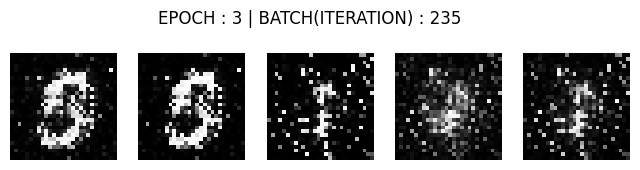

[Epoch 2/10] [D loss: 0.5301957130432129] [G loss: 0.6089228391647339]


 20%|█▉        | 939/4700 [01:23<05:51, 10.71it/s]

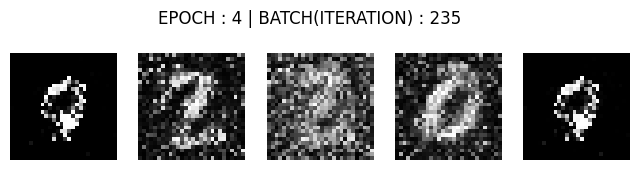

 20%|██        | 941/4700 [01:24<06:17,  9.97it/s]

[Epoch 3/10] [D loss: 0.5430375337600708] [G loss: 0.7935382723808289]


 25%|██▍       | 1174/4700 [01:45<05:57,  9.86it/s]

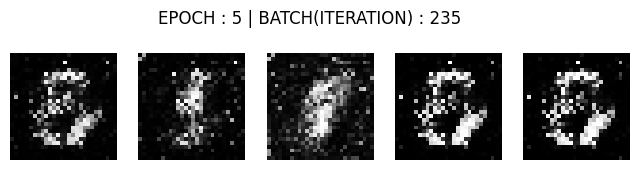

 25%|██▌       | 1176/4700 [01:45<06:35,  8.92it/s]

[Epoch 4/10] [D loss: 0.6347503066062927] [G loss: 2.644627094268799]


 30%|██▉       | 1409/4700 [02:06<04:56, 11.09it/s]

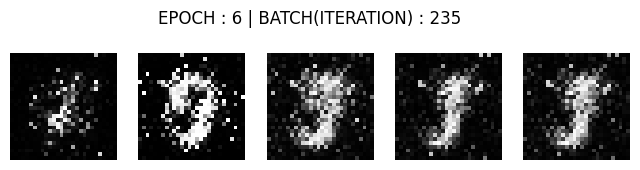

 30%|███       | 1411/4700 [02:06<05:13, 10.48it/s]

[Epoch 5/10] [D loss: 0.46252986788749695] [G loss: 0.6569867134094238]


 35%|███▌      | 1645/4700 [02:26<04:00, 12.71it/s]

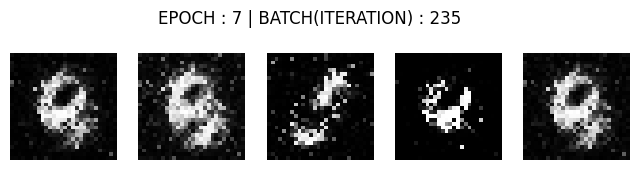

 35%|███▌      | 1647/4700 [02:26<04:38, 10.97it/s]

[Epoch 6/10] [D loss: 0.4432487487792969] [G loss: 0.9084278345108032]


 40%|███▉      | 1879/4700 [02:45<04:26, 10.57it/s]

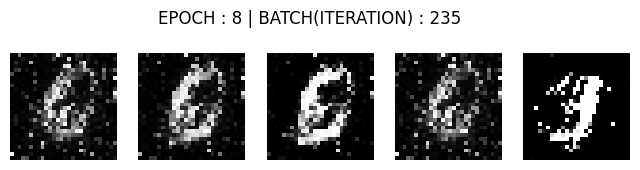

 40%|████      | 1881/4700 [02:45<04:54,  9.57it/s]

[Epoch 7/10] [D loss: 0.47682440280914307] [G loss: 2.1114537715911865]


 45%|████▍     | 2114/4700 [03:06<03:54, 11.02it/s]

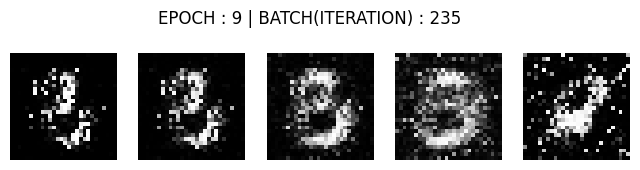

 45%|████▌     | 2116/4700 [03:07<04:10, 10.32it/s]

[Epoch 8/10] [D loss: 0.44246408343315125] [G loss: 0.7450372576713562]


 50%|█████     | 2350/4700 [03:28<03:15, 12.01it/s]

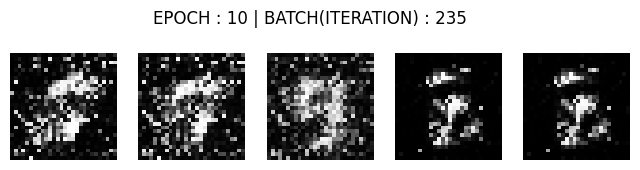

 50%|█████     | 2352/4700 [03:28<03:44, 10.46it/s]

[Epoch 9/10] [D loss: 0.4094160199165344] [G loss: 2.242755174636841]


 55%|█████▍    | 2584/4700 [03:52<03:13, 10.94it/s]

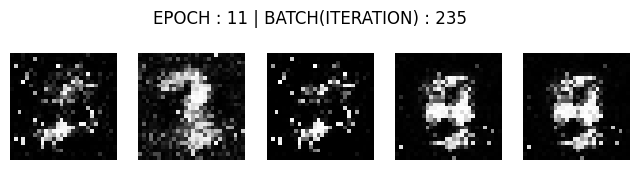

 55%|█████▌    | 2586/4700 [03:52<03:27, 10.21it/s]

[Epoch 10/10] [D loss: 0.36712393164634705] [G loss: 2.796440839767456]


 60%|██████    | 2820/4700 [04:16<02:31, 12.44it/s]

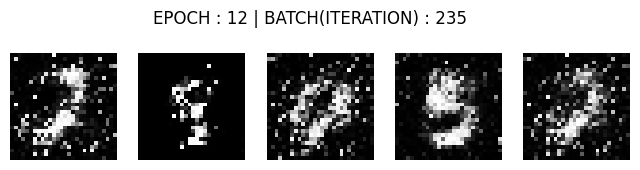

 60%|██████    | 2822/4700 [04:17<03:06, 10.07it/s]

[Epoch 11/10] [D loss: 0.3169329762458801] [G loss: 0.9355545043945312]


 65%|██████▍   | 3054/4700 [04:37<02:26, 11.26it/s]

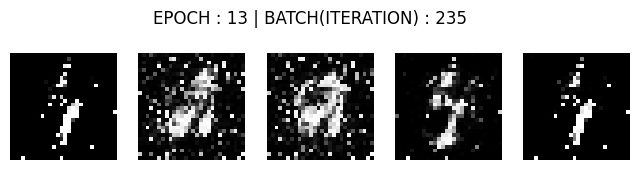

 65%|██████▌   | 3056/4700 [04:37<02:43, 10.04it/s]

[Epoch 12/10] [D loss: 0.34463366866111755] [G loss: 0.9270862936973572]


 70%|███████   | 3290/4700 [04:57<01:55, 12.16it/s]

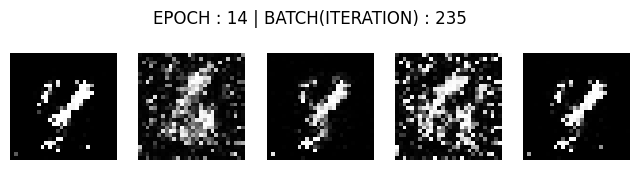

 70%|███████   | 3292/4700 [04:57<02:18, 10.20it/s]

[Epoch 13/10] [D loss: 0.28200021386146545] [G loss: 1.1190800666809082]


 75%|███████▍  | 3524/4700 [05:17<01:47, 10.98it/s]

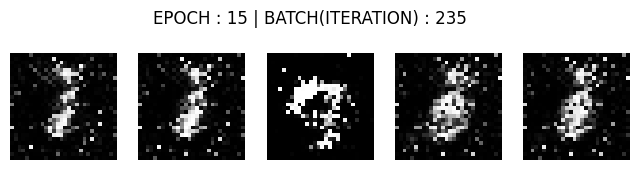

 75%|███████▌  | 3526/4700 [05:17<01:53, 10.32it/s]

[Epoch 14/10] [D loss: 0.6975716948509216] [G loss: 4.284712314605713]


 80%|████████  | 3760/4700 [05:37<01:08, 13.69it/s]

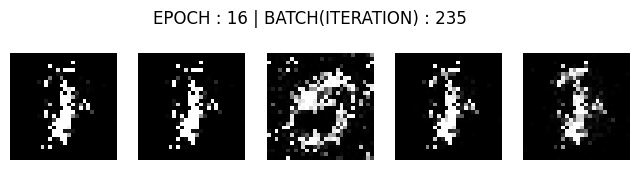

 80%|████████  | 3762/4700 [05:37<01:21, 11.45it/s]

[Epoch 15/10] [D loss: 0.20016337931156158] [G loss: 2.787417411804199]


 85%|████████▍ | 3994/4700 [05:58<01:02, 11.25it/s]

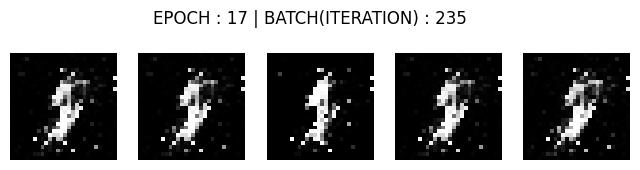

 85%|████████▌ | 3996/4700 [05:59<01:09, 10.11it/s]

[Epoch 16/10] [D loss: 0.2584491968154907] [G loss: 1.3318356275558472]


 90%|█████████ | 4230/4700 [06:19<00:42, 11.17it/s]

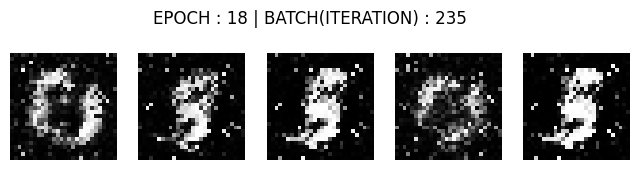

[Epoch 17/10] [D loss: 0.2178318202495575] [G loss: 3.1499927043914795]


 95%|█████████▍| 4464/4700 [06:40<00:22, 10.57it/s]

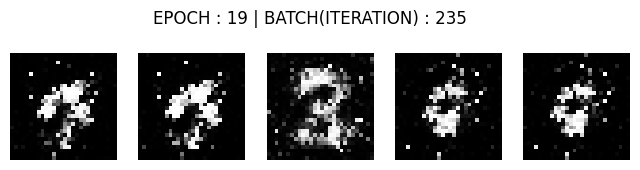

 95%|█████████▌| 4466/4700 [06:41<00:23,  9.92it/s]

[Epoch 18/10] [D loss: 0.2775939404964447] [G loss: 1.301876425743103]


100%|██████████| 4700/4700 [07:02<00:00, 11.75it/s]

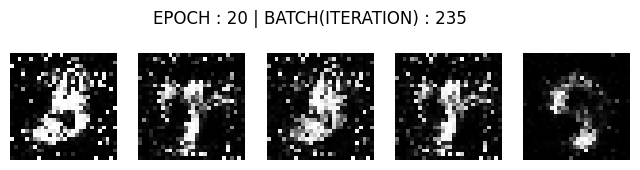

[Epoch 19/10] [D loss: 0.2212623804807663] [G loss: 1.6305269002914429]


100%|██████████| 4700/4700 [07:19<00:00, 11.75it/s]

In [11]:
from tqdm import tqdm

epochs = 20

process = tqdm(range(epochs * len(train_loader)))
step = 0

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)
        
        real_imgs = imgs.to(device)
        
        optimizer_G.zero_grad()
        
        z = torch.randn(imgs.size(0), 100).to(device)
        gen_imgs = generator(z)
        
        g_loss = loss_fn(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()
        
        real_loss = loss_fn(discriminator(real_imgs), valid)
        fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        sample_z_in_train = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0] ,100))).to(device)
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        
        step += 1
        process.update(1)
        
    nrow=1
    ncols=5
    fig, axs = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8, 2))
    plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
    
    for ncol in range(ncols):
        axs[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
        axs[ncol].axis('off')
    
    plt.show()
    print(f"[Epoch {epoch}/{10}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

In [12]:
generator.eval()
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [13]:
sample_z = torch.Tensor(np.random.normal(0, 1, (64,100))).to(device)
sample_z.shape

torch.Size([64, 100])

In [18]:
sample_gen_imgs = generator(sample_z).detach().cpu()
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [23]:
gen_img = generator(torch.randn(1, 100).to(device)).detach().cpu().numpy().reshape(28, 28)

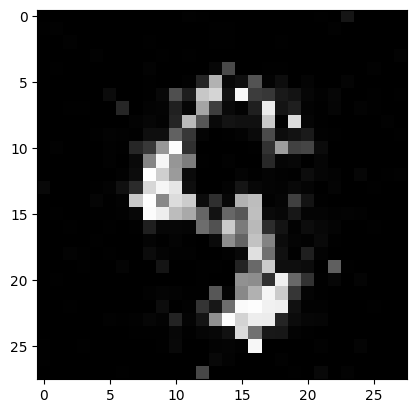

In [24]:
plt.imshow(gen_img, cmap='gray')